In [10]:
%matplotlib inline
#%pylab
import os
import matplotlib, commands
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.stats
from scipy import interpolate
import pandas as pd
import itertools
import pdb

In [11]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={'vgg16a' : 'sp_vgg16a_iter_',
           'vgg16b' : 'sp_vgg16b_iter_',
           'vgg16c' : 'sp_vgg16c_iter_',
           'resnet14b'    : 'sp_resnet14b_iter_',
           'resnet14b_w4' : 'sp_resnet14b_w4_iter_',
           'resnet29b'    : 'sp_resnet29b_iter_',
           'resnet29b_w2' : 'sp_resnet29b_w2_iter_',
           'resnet29b_w4' : 'sp_resnet29b_w4_iter_',
           'resnet50b'    : 'sp_resnet50b_iter_',
           'plainresnet10b'    : 'sp_plainresnet10b_iter_',
           'plainresnet10b_w4' : 'sp_plainresnet10b_w4_iter_',
           'plainresnet12b'    : 'sp_plainresnet12b_iter_',
           'plainresnet18b'    : 'sp_plainresnet18b_iter_',
           'plainresnet18b_w4' : 'sp_plainresnet18b_w4_iter_',
           'plainresnet20b'    : 'sp_plainresnet20b_iter_',
           'plainresnet20b_w4' : 'sp_plainresnet20b_w4_iter_'
          }
_DATAMAP_={}
_FILEDIR_='testA'
_LABELS_=['eminus','gamma','muminus','piminus','proton']

In [3]:
def list_itr(netname):
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    f = _FILEDIR_ + '/' + _FILEMAP_[netname]
    itr_v = [int(f.rstrip('.csv').split('_')[-1]) for f in commands.getoutput('ls %s*csv' % f).split() if f.endswith('csv')]
    itr_v.sort()
    return itr_v

def get_df(netname,itr):
    key=(netname,itr)
    if key in _DATAMAP_:
        return _DATAMAP_[key]
    
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    
    itr_v = list_itr(netname)
    if not itr in itr_v:
        print 'Iteration',itr,'not found'
        return None

    f = _FILEDIR_ + '/' + _FILEMAP_[netname] + str(itr) + '.csv'
    if not os.path.isfile(f):
        print 'LOGIC ERROR ... file not found (should not happen):',f
        return None
    
    df = pd.read_csv(f)
    _DATAMAP_[key] = df
    return _DATAMAP_[key]

def get_accuracy(netname,labels,names):
    if not len(labels) == len(names):
        print '# labels and # names do not match...'
        return None
    for label in labels:
        if not type(label) == type(list()):
            print 'Labels must be of list type'
            return None
        
    # Report available list of iterations
    itr_v = list_itr(netname)
    print 'Iterations',itr_v
    print

    res = {'all_combined':[]}
    for name in names:
        res[name] = []

    # Loop over iterations and print accuracy
    for itr in itr_v:
        # Get data frame
        df = get_df(netname,itr)

        # Compute overall accuracy
        numerator = ''
        for label in labels:
            if numerator: numerator += ' or '
            numerator += '((label in %s) and (prediction in %s))' % (str(label),str(label))
        denominator = ''
        for label in labels:
            if denominator: denominator += ' or '
            denominator += '(label in %s)' % str(label)

        total = float(len(df.query(denominator)))
        acc = 0.
        if total > 0.:
            acc = len(df.query(numerator)) / total
        acc = int(acc*10000)/100.
        res['all_combined'].append(acc)

        # compute per-label accuracy
        for idx in xrange(len(labels)):
            label = labels[idx]
            name  = str(names[idx])
            numerator   = '((label in %s) and (prediction in %s))' % (str(label),str(label))
            denominator = '(label in %s)' % str(label)
            total = float(len(df.query(denominator)))
            acc = 0.
            if total >= 1.:
                acc = len(df.query(numerator)) / total
            acc = int(acc*10000/100.)
            res[name].append(acc)
    
    res['Iteration'] = itr_v
    res = pd.DataFrame(res)
    return res


Network vgg16a

Iterations [139500, 139750, 140000, 140250, 140500, 140750, 141000, 141250, 141500, 141750, 142000, 142250, 142500, 142750, 143000, 143250, 143500, 143750, 144000, 144250, 144500, 144750, 145000, 145250, 145500, 145750, 146000]

Result:
    Iteration  all_combined  eminus  eminus_ctr  gamma  gamma_ctr  muminus  \
0      139500         86.02   88.20      2500.0  87.16     2500.0    91.08   
1      139750         86.74   89.08      2500.0  84.60     2500.0    92.96   
2      140000         86.43   86.84      2500.0  83.08     2500.0    91.48   
3      140250         86.40   88.96      2500.0  85.40     2500.0    88.96   
4      140500         86.18   84.92      2500.0  89.96     2500.0    91.80   
5      140750         85.93   85.04      2500.0  86.20     2500.0    94.12   
6      141000         86.82   84.60      2500.0  88.12     2500.0    90.12   
7      141250         86.48   88.72      2500.0  83.04     2500.0    88.92   
8      141500         86.42   84.80      2500

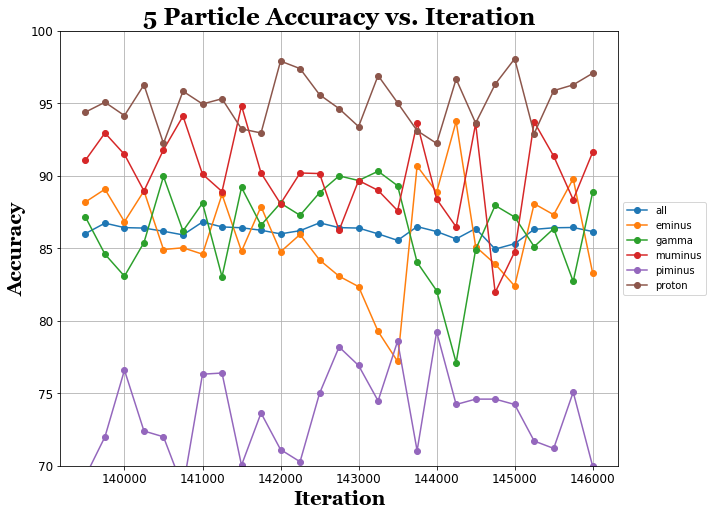

In [12]:
#
# Analysis: try printing accuracy per iteration
#

#
# Configurations
#
# network name
netname='vgg16a'

# Report network name
print 'Network',netname
print

# Report available list of iterations
itr_v = list_itr(netname)
print 'Iterations',itr_v
print

res={'all_combined':[]}
for l in _LABELS_:
    res[l]=[]
    res['%s_ctr' % l]=[]

# Loop over iterations and print accuracy
for itr in itr_v:
    # Get data frame
    df = get_df(netname,itr)
    # Compute overall accuracy
    acc = len(df.query('label==prediction')) / float(len(df))
    acc = int(acc*10000)/100.
    res['all_combined'].append(acc)
    
    # Compute per-particle accuracy
    for idx in xrange(len(_LABELS_)):
        label = _LABELS_[idx]
        total = float(len(df.query('label==%d' % idx)))
        res['%s_ctr' % label].append(total)
        
        if total<1.:
            res[label].append(0.)
        else:
            acc = len(df.query('label==prediction and label==%d' % idx)) / total
            acc = int(acc*10000)/100.
            res[label].append(acc)

res['Iteration'] = itr_v
res = pd.DataFrame(res)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')
plt.plot(res.Iteration.values,res.eminus.values,label='eminus',marker='o')
plt.plot(res.Iteration.values,res.gamma.values,label='gamma',marker='o')
plt.plot(res.Iteration.values,res.muminus.values,label='muminus',marker='o')
plt.plot(res.Iteration.values,res.piminus.values,label='piminus',marker='o')
plt.plot(res.Iteration.values,res.proton.values,label='proton',marker='o')
leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,100)
plt.savefig("part5_vggc.png")

Network vgg16a

Iterations [139500, 139750, 140000, 140250, 140500, 140750, 141000, 141250, 141500, 141750, 142000, 142250, 142500, 142750, 143000, 143250, 143500, 143750, 144000, 144250, 144500, 144750, 145000, 145250, 145500, 145750, 146000]

Result:
    Iteration  all_combined  shower  track
0      139500         98.41      99     97
1      139750         98.90      98     99
2      140000         98.50      96     99
3      140250         98.87      99     98
4      140500         98.72      99     98
5      140750         98.82      98     99
6      141000         98.90      98     98
7      141250         98.60      97     99
8      141500         98.85      98     99
9      141750         98.57      99     98
10     142000         98.84      98     98
11     142250         98.67      98     98
12     142500         98.76      98     99
13     142750         98.88      98     99
14     143000         98.83      98     99
15     143250         98.74      98     99
16     143500   

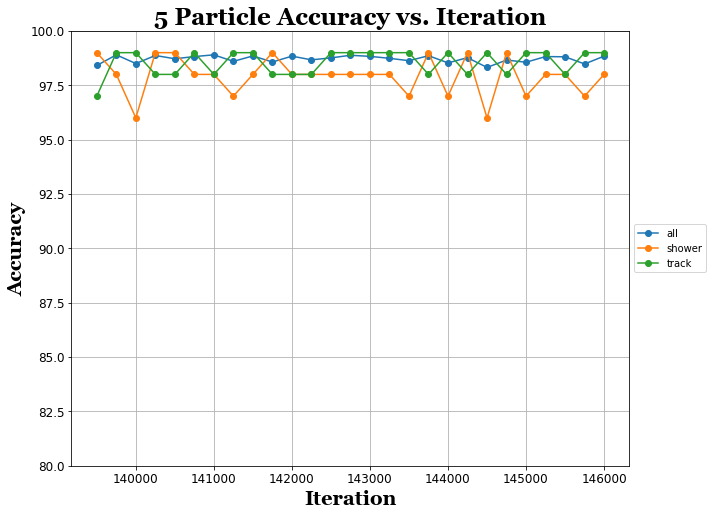

In [13]:
#
# Analyze shower/track
#

#
# Configurations
#
# network name
netname='vgg16a'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['shower','track']
labels = [[0,1], [2,3,4]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(80,100)
#plt.show()
plt.savefig("part_show-trk_vggc.png")

Network vgg16a

Iterations [139500, 139750, 140000, 140250, 140500, 140750, 141000, 141250, 141500, 141750, 142000, 142250, 142500, 142750, 143000, 143250, 143500, 143750, 144000, 144250, 144500, 144750, 145000, 145250, 145500, 145750, 146000]

Result:
    Iteration  all_combined  eminus  gamma
0      139500         87.68      88     87
1      139750         86.84      89     84
2      140000         84.96      86     83
3      140250         87.18      88     85
4      140500         87.44      84     89
5      140750         85.62      85     86
6      141000         86.36      84     88
7      141250         85.88      88     83
8      141500         87.00      84     89
9      141750         87.24      87     86
10     142000         86.44      84     88
11     142250         86.62      85     87
12     142500         86.52      84     88
13     142750         86.54      83     90
14     143000         86.02      82     89
15     143250         84.80      79     90
16     143500   

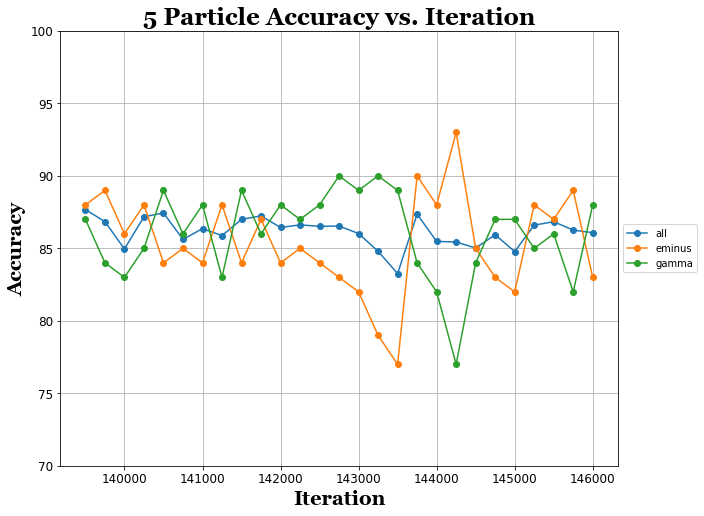

In [14]:
#
# Analyze e/gamma
#

#
# Configurations
#
# network name
netname='vgg16a'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['eminus','gamma']
labels = [[0], [1]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,100)
#plt.show()
plt.savefig("part_e-gamma_vggc.png")

Network vgg16a

Iterations [139500, 139750, 140000, 140250, 140500, 140750, 141000, 141250, 141500, 141750, 142000, 142250, 142500, 142750, 143000, 143250, 143500, 143750, 144000, 144250, 144500, 144750, 145000, 145250, 145500, 145750, 146000]

Result:
    Iteration  all_combined  muminus  piminus
0      139500         80.18       91       69
1      139750         82.48       92       72
2      140000         84.04       91       76
3      140250         80.68       88       72
4      140500         81.89       91       72
5      140750         81.29       94       68
6      141000         83.22       90       76
7      141250         82.66       88       76
8      141500         82.44       94       70
9      141750         81.92       90       73
10     142000         79.60       88       71
11     142250         80.24       90       70
12     142500         82.58       90       75
13     142750         82.22       86       78
14     143000         83.30       89       76
15     1432

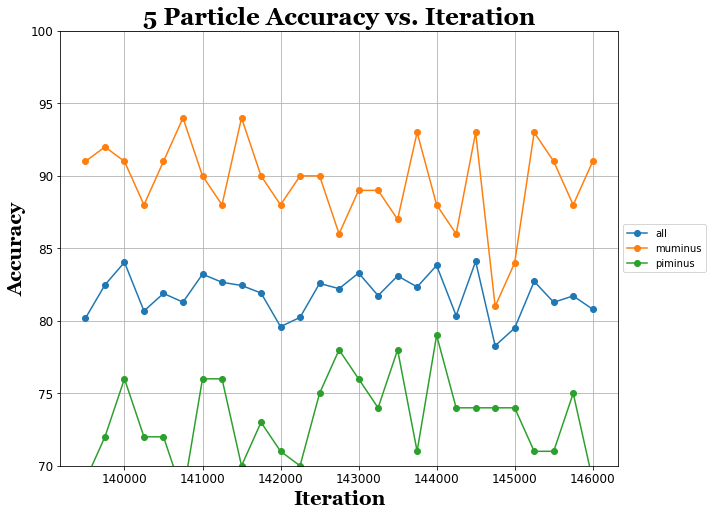

In [15]:
#
# Analyze mu/pi
#

#
# Configurations
#
# network name
netname='vgg16a'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['muminus','piminus']
labels = [[2], [3]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,100)
#plt.show()
plt.savefig("part_mu-pi_vggc.png")